# University of Stavanger
## ELE510 - Computer vision and image processing final project.
Image denoising of multiplicative speckle noise

## Authors
* Asahi Cantu
* Ali Akbar

## Extracting image sources from knwon web hosts

In [1]:
% pip install tqdm
% pip install numpy
% pip install matplotlib
% pip install opencv-python
% pip install sklearn
% pip install findpeaks

UsageError: Line magic function `%` not found.


In [2]:
import sys
import os
import urllib
import zipfile
from tqdm import notebook
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

img_dir = 'img'
img_urls=[
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH01_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH02_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH03_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH04_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH05_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH06_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH07_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH08_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH08_Original_Video_Clips.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH09_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH10_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH11_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_CH12_Original_Images.zip",
"http://www.imageprocessingplace.com/downloads_V3/dip3e_downloads/dip3e_book_images/DIP3E_Problem_Figures.zip"
]

In [ ]:
for i, img_url in enumerate(img_urls):
    file_name = os.path.join(img_dir,img_url.split('/')[-1])
    print(f'Downloading {i+1} from {len(img_urls)} {img_url} into {file_name}...')
    urllib.request.urlretrieve(img_url, file_name)
    print(f'Decompressing {file_name}....')
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_files = [f for f in zip_ref.filelist if '.tif' in f.filename]
        for j, zip_file in enumerate(zip_files):
            zip_file.filename = os.path.basename(zip_file.filename)
            print(f'\t Extracting {j+1} of {len(zip_files)} {zip_file.filename}...')
            zip_ref.extract(zip_file, img_dir)
    os.remove(file_name)

## Selecting suitable image case studies

In [3]:
img_cases = [
#     'Fig0221(a)(ctskull-256).tif',
    'Fig0222(a)(face).tif',
    'Fig0222(b)(cameraman).tif',
#     'Fig0507(a)(ckt-board-orig).tif',
#     'Fig0519(a)(florida_satellite_original).tif',
#     'Fig1138(d)(WashingtonDC_Band4_564).tif',
#     'FigP0421(right)(center-padded_image).tif',
#     'FigP0436(a).tif',
#     'Fig0726(a).tif',
#     'Fig0117(a)(MRI-of-knee-Univ-Mich).tif',
#     'Fig0116(Radar_Tibet_Mountains-highres).tif'
    ]

## Creating random spekle noise in candidate casses

In [4]:
def set_subplot_settings(img, ax, title):
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

In [5]:
%pip install findpeaks

Note: you may need to restart the kernel to use updated packages.


The filename, directory name, or volume label syntax is incorrect.


In [6]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise

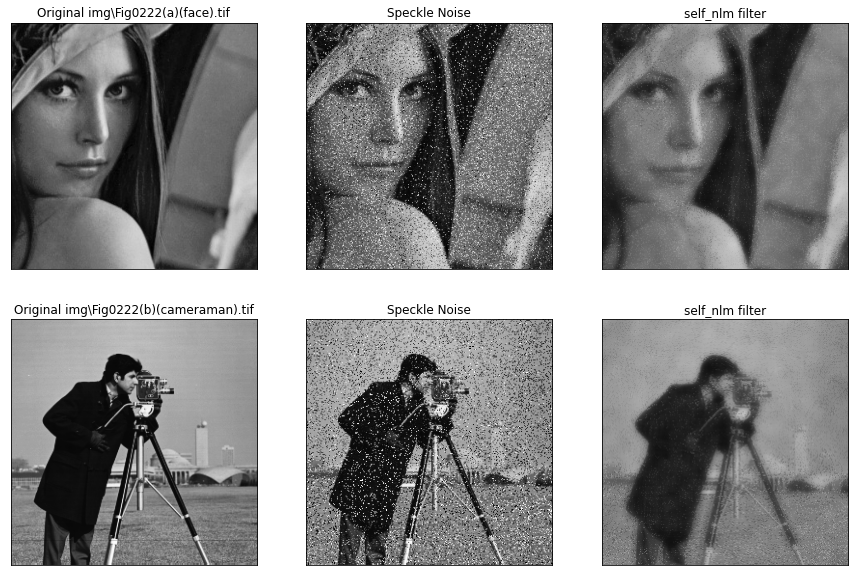

In [35]:
import imp
import numpy as np
import matplotlib.pyplot as plt
import cv2
import noise
from PIL import Image, ImageFilter
imp.reload(noise)

# denoise_types = [noise.DENOISE_TYPE_MEDIAN]
# denoise_types = [noise.DENOISE_TYPE_CV_NLM]
denoise_types = [noise.DENOISE_TYPE_SELF_NLM]
fig, axs = plt.subplots(len(img_cases), 3 , figsize=(15 * len(denoise_types), 5 * len(img_cases)), sharex=False, sharey=False)
for i,img_case in  enumerate(img_cases) :
    img_case = os.path.join(img_dir, img_case)
    img = cv2.imread(img_case, cv2.IMREAD_GRAYSCALE)
    img_noise = noise.noisify_speckle(img)
    set_subplot_settings(img, axs[i,0], f'Original {img_case}')
    set_subplot_settings(img_noise, axs[i,1], 'Speckle Noise')

    for j,filter in enumerate(denoise_types):
        if filter == noise.DENOISE_TYPE_CV_NLM:
            img_denoise = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
        if filter == noise.DENOISE_TYPE_SELF_NLM:
            params = (20, 6)
            img_denoise = noise.denosify(filter, img_noise, params)
        if filter == noise.DENOISE_TYPE_MEDIAN:
            params = (5)
            img_denoise = noise.denosify(filter, img_noise, params)
        # Sharpening image after denoising
        img_sharpened = Image.fromarray(img_denoise.astype('uint8'))
        img_sharpened = img_sharpened.filter(ImageFilter.UnsharpMask(radius = 1, percent = 100))
        set_subplot_settings(img_denoise, axs[i,j+2], filter + " filter")
plt.show()    